# FISH - Pipeline - A Python interactive notebook to process FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Notebook summary 


- Load a directory with microscope FISH images
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Perform cell segmentation using [Cellpose](https://github.com/MouseLand/cellpose)
- Perform spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Datamanagement using Pandas

----

### Libraries

In [1]:
# Importing libraries
import sys
import pathlib
import warnings
import matplotlib.pyplot as plt
import pycromanager as pycro

warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [3]:
current_dir

PosixPath('/Users/luisaguilera/Desktop/FISH_Processing/notebooks')

In [4]:
fa.Banner().print_banner()

 
FISH processing repository by : 
Luis U. Aguilera, Joshua Cook, Tim Stasevich, and Brian Munsky. 
 ____________________________________________________________  
|                      ,#^^^^^^^%&&&                         | 
|  .&.                 &.           ,&&&___                  | 
|  &  &         ___&&&/                    (&&&&____         | 
|  &    &,____#&                   .       #.       %&**,    | 
|  /(                  &         ,%       &       %     ,&   | 
|    &          &.                       %.      %&%     &*  | 
|     &&         *         .%            &             &(    | 
|   &                &(           ,#     .%             ,.&  | 
|  &    _&&__#&.     &&           &.      ,&         ,%&     | 
|  &  (%        #&,___                      (-***%&%^        | 
|  & &                %&&&(,.      .*#&&&&&%.                | 
|                          &    ,%%%%                        | 
|___________________________/%%^_____________________________| 



----

# Parameters defined by the user 

----

### Paths to images

In [5]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')

data_folder_path =pathlib.Path('Users/Jack/06142024_HeLa_DexPulse_10nM/rep1_3min_zStacksAtSelectedLocations_1')
data_folder_path =pathlib.Path('/Users/luisaguilera/Desktop/FISH_Processing/notebooks/rep1_3min_zStacksAtSelectedLocations_1')
channels_with_nucleus=[2]         # Channel to pass to python for nucleus segmentation
channels_with_cytosol=[1]         # Channel to pass to python for cytosol segmentation
channels_with_FISH=[0]             # Channel to pass to python for spot detection
path_to_masks_dir=None #pathlib.Path('smFISH_images/Eric_smFISH_images/20230511/GR_ICC_3hr_R1_1nM_0min_050823/masks_GR_ICC_3hr_R1_1nM_0min_050823___nuc_100__cyto_200.zip')

data_folder_path

PosixPath('/Users/luisaguilera/Desktop/FISH_Processing/notebooks/rep1_3min_zStacksAtSelectedLocations_1')

In [6]:
# Cellpose models

nuclei_model_path = None #'/home/luisub/Desktop/FISH_Processing/cell_segmentation/temp_models/nuclei_gapdh/nuclei_gapdh'
cyto_model_path =  None #'/home/luisub/Desktop/FISH_Processing/cell_segmentation/temp_models/cyto_gapdh/cyto_gapdh'

### Parameters for segmentation and spot detection

In [7]:
diameter_nucleus=100                         # Approximate nucleus size in pixels
diameter_cytosol=200                         # Approximate cytosol size in pixels

psf_z=350                                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx=130                                   # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers

voxel_size_z=500                             # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=130                            # Microscope conversion px to nanometers in the xy axis.

optimization_segmentation_method= None #'default'  # optimization_segmentation_method = 'default', 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' , None
save_all_images=0                             # To save all images for all the z-slices
save_filtered_images = True                 # To save filtered images.
number_of_images_to_process = 2 #None           # Use an integer to process a subset of images. None is used to indicate that all images need to be processed.
minimum_spots_cluster = 4                    # Minimal value used to define a cluster.
threshold_for_spot_detection=None            # To select an specific threshold for spot detection. The default is None, and use automated threshold detection.
show_plots=1                                 # Flag to show plots
send_data_to_NAS=0                           # If data sent back to NAS use 1
download_data_from_NAS=0                     # If data downloaded from NAS use 1
remove_z_slices_borders=0                    # Use this flag to remove 2 z-slices from the top and bottom of the stack. This is needed to remove z-slices that are out of focus.
save_pdf_report=1
display_spots_on_multiple_z_planes=0
remove_out_of_focus_images = 0
sharpness_threshold =1.10


## Downloading data from NAS

In [8]:
# %%capture
# Download data from NAS
convert_to_standard_format = True
if convert_to_standard_format == False:
    local_data_dir, masks_dir, _, _, _,list_images = fa.Utilities().read_images_from_folder( path_to_config_file, data_folder_path, path_to_masks_dir,  download_data_from_NAS)
    number_color_channels = list_images[0].shape[-1]
else:
    ####################################################################
    #### Parameters to reformat images from the terminator scope ####
    #number_color_channels = std_info[key_of_file]['channel']                    # Only use if it is needed to convert to standard format
    #number_of_fov = std_info[key_of_file]['position']                            # Only use if it is needed to convert to standard format     
    ####################################################################
    local_data_dir, masks_dir, _, _, list_images= fa.Utilities().convert_to_standard_format(data_folder_path=data_folder_path, 
                                                                                            path_to_config_file=path_to_config_file, 
                                                                                            download_data_from_NAS = download_data_from_NAS,
                                                                                            use_metadata=True,
                                                                                            is_format_FOV_Z_Y_X_C=True)

Dataset opened                
Number of z slices:  15 
 Number of color channels:  3 
Number of FOV:  70 
 
 

Image shape:  (70, 15, 512, 512, 3) 

Number of images:  1 

Local directory with images:  /Users/luisaguilera/Desktop/FISH_Processing/notebooks/rep1_3min_zStacksAtSelectedLocations_1 



## Running the pipeline

----


 Output folder name :  rep1_3min_zStacksAtSelectedLocations_1_sf___nuc_100__cyto_200__psfz_350__psfyx_130__ts_None

 ###################### 
        IMAGE : 0
 ###################### 
    Image Name :   rep1_0min_zStacksAtSelectedLocations_NDTiffStack_fov_0.tif


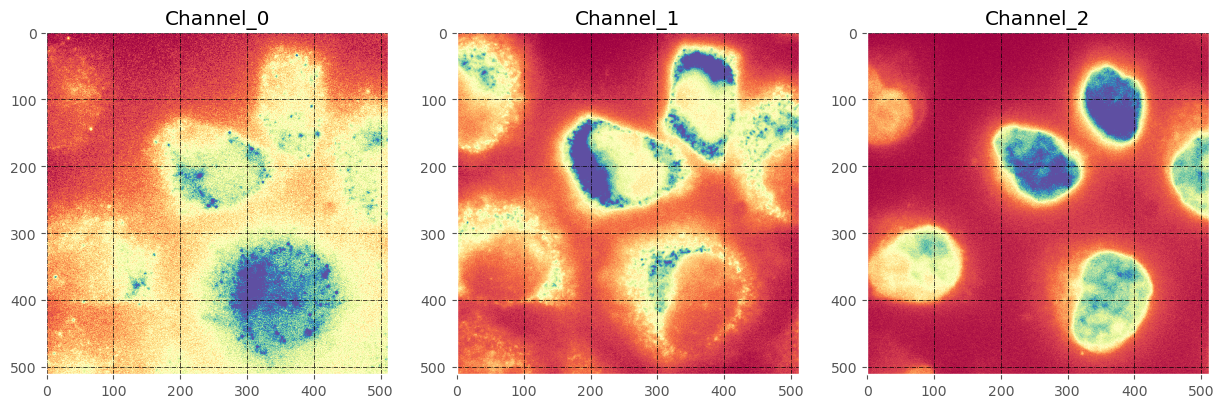

    Original Image Shape :                    [15, 512, 512, 3]
    Image sharpness metric :                  1.096
    Number of detected cells:                 5


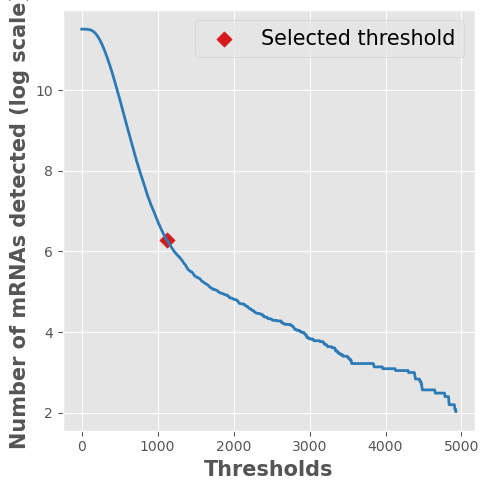

Z-Slice:  7


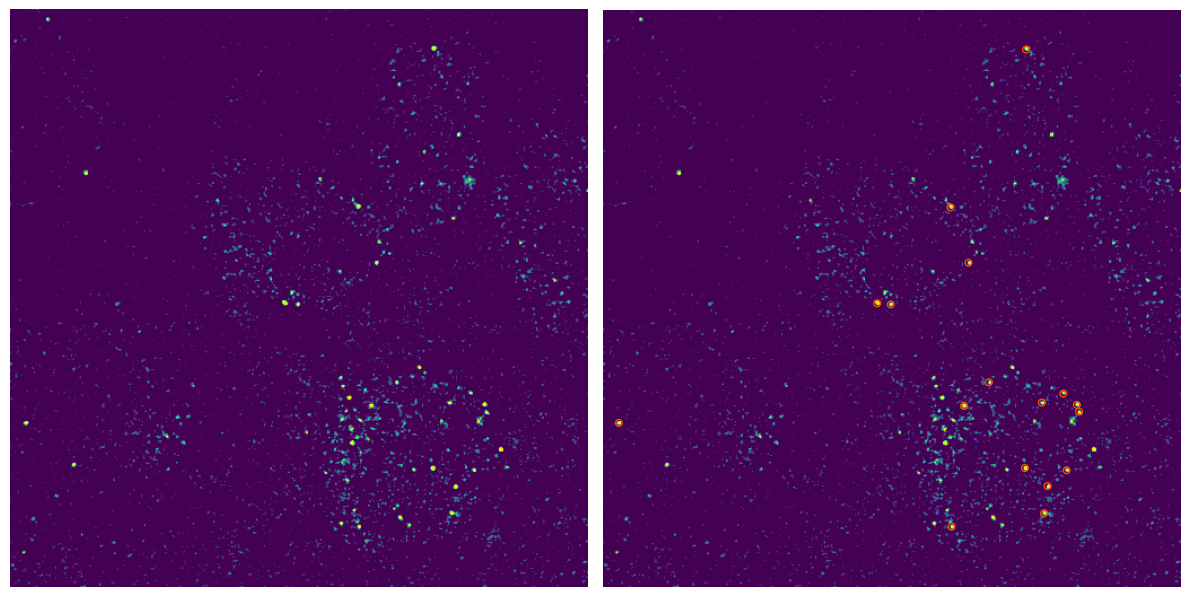

    Intensity threshold for spot detection :  [1122.0]
    Average detected spots per cell :         [95]
    Maximum detected spots per cell :         [225]


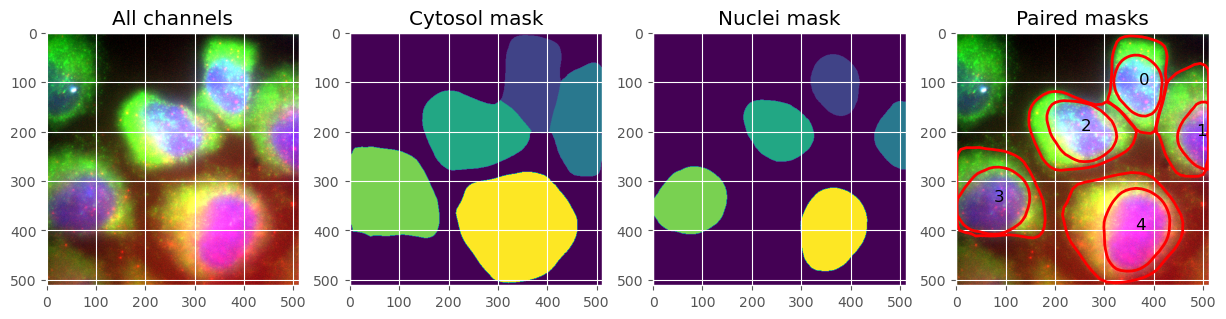


 ###################### 
        IMAGE : 1
 ###################### 
    Image Name :   rep1_0min_zStacksAtSelectedLocations_NDTiffStack_fov_1.tif


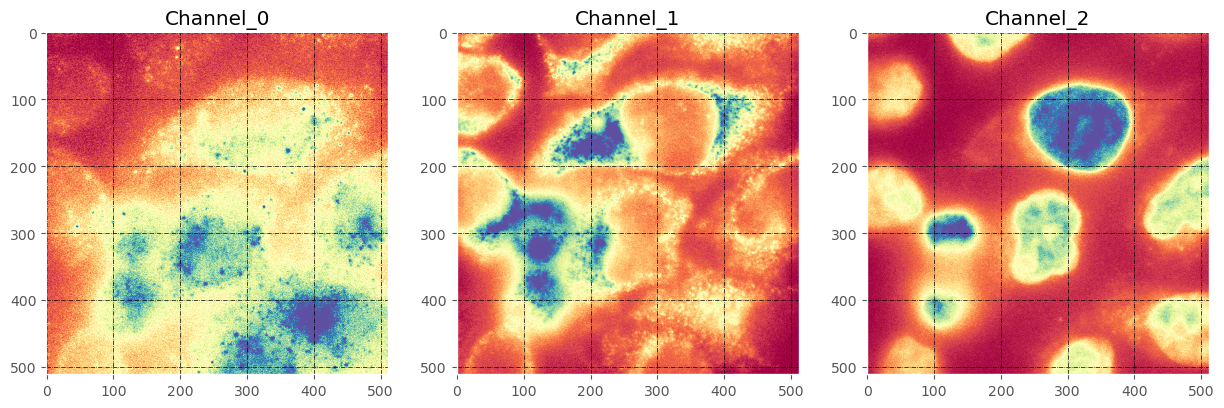

    Original Image Shape :                    [15, 512, 512, 3]
    Image sharpness metric :                  1.097
    Number of detected cells:                 9


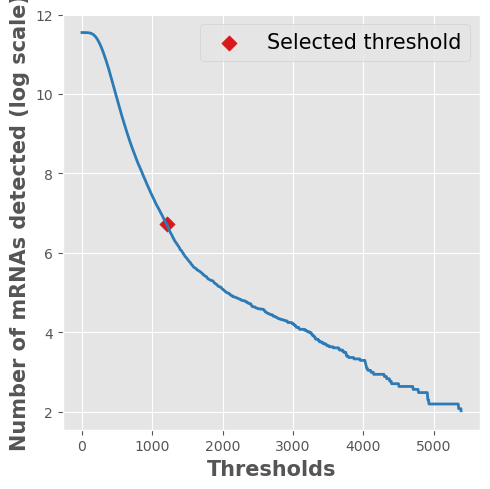

Z-Slice:  7


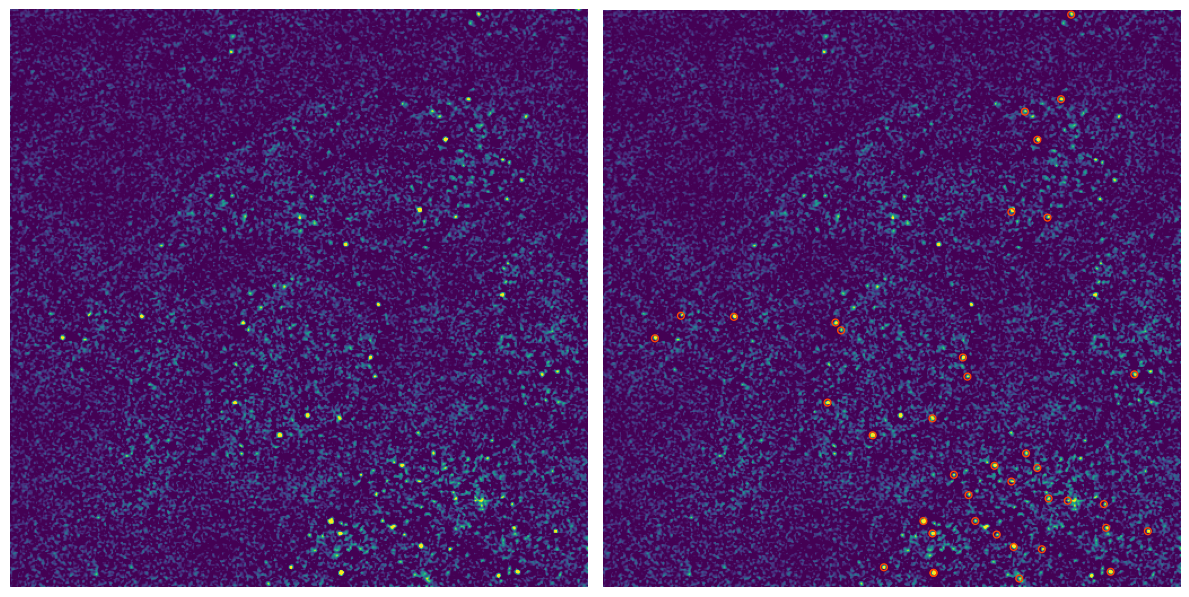

    Intensity threshold for spot detection :  [1204.0]
    Average detected spots per cell :         [76]
    Maximum detected spots per cell :         [195]


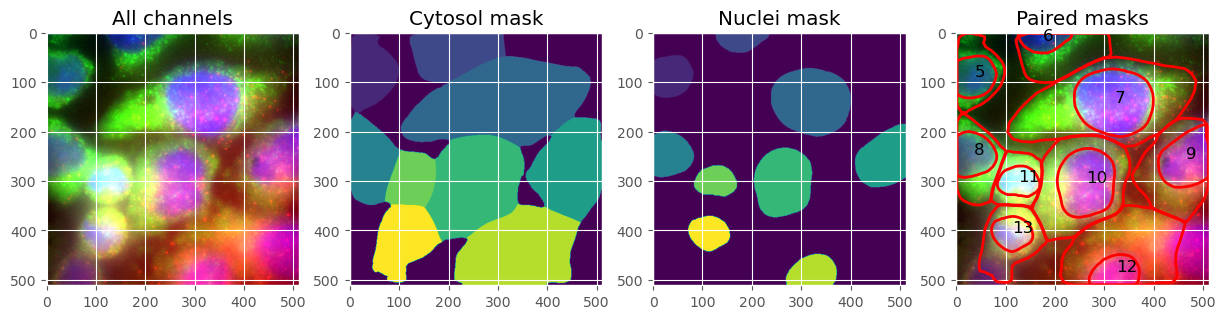

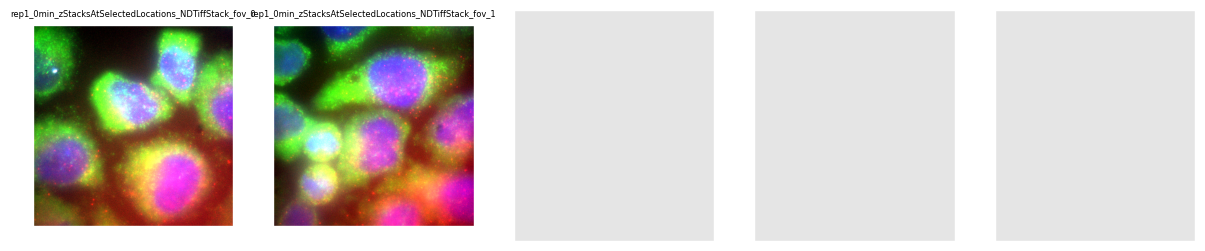

In [9]:
dataframe_FISH,_,_,_,output_identification_string = fa.PipelineFISH(local_data_dir,
                                                                    channels_with_cytosol,
                                                                    channels_with_nucleus, 
                                                                    channels_with_FISH,diameter_nucleus, 
                                                                    diameter_cytosol, 
                                                                    minimum_spots_cluster, 
                                                                    masks_dir=masks_dir, 
                                                                    voxel_size_z=voxel_size_z,
                                                                    voxel_size_yx=voxel_size_yx ,
                                                                    psf_z=psf_z,psf_yx=psf_yx, 
                                                                    show_plots=show_plots,  
                                                                    file_name_str=data_folder_path.name, 
                                                                    optimization_segmentation_method=optimization_segmentation_method,
                                                                    save_all_images=save_all_images,
                                                                    threshold_for_spot_detection=threshold_for_spot_detection,
                                                                    save_filtered_images=save_filtered_images,
                                                                    number_of_images_to_process=number_of_images_to_process,
                                                                    remove_z_slices_borders=remove_z_slices_borders,
                                                                    save_pdf_report=save_pdf_report,
                                                                    display_spots_on_multiple_z_planes=display_spots_on_multiple_z_planes,
                                                                    model_nuc_segmentation='nuclei', # ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4']
                                                                    model_cyto_segmentation='cyto', # ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4']
                                                                    pretrained_model_nuc_segmentation=None, #nuclei_model_path,
                                                                    remove_out_of_focus_images=remove_out_of_focus_images,
                                                                    pretrained_model_cyto_segmentation=cyto_model_path ).run()

## Extracting data from the dataframe

----

In [10]:
# Be aware that the code keeps track of cells without spots. In the data frame, the fields for cells without spots are populated with -1 values.
dataframe_FISH.head()

image_id  cell_id  spot_id  nuc_loc_y  nuc_loc_x  cyto_loc_y  cyto_loc_x  \
0         0        0        0        105        369          97         369   
1         0        0        1        105        369          97         369   
2         0        0        2        105        369          97         369   
3         0        0        3        105        369          97         369   
4         0        0        4        105        369          97         369   

   nuc_area_px  cyto_area_px  cell_area_px  ...  pseudo_cyto_int_ch_2  \
0         9482          8876         18358  ...            4824.64279   
1         9482          8876         18358  ...            4824.64279   
2         9482          8876         18358  ...            4824.64279   
3         9482          8876         18358  ...            4824.64279   
4         9482          8876         18358  ...            4824.64279   

   nuc_cyto_int_ratio_ch_0  nuc_cyto_int_ratio_ch_1  nuc_cyto_int_ratio_ch_2  \
0                 1.172608                 1.001198                 2.730148   
1                 1.172608                 1.001198                 2.730148   
2                 1.172608                 1.001198                 2.730148   
3                 1.172608                 1.001198                 2.730148   
4                 1.172608                 1.001198                 2.730148   

   nuc_pseudo_cyto_int_ratio_ch_0  nuc_pseudo_cyto_int_ratio_ch_1  \
0                         1.16923                        1.059457   
1                         1.16923                        1.059457   
2                         1.16923                        1.059457   
3                         1.16923                        1.059457   
4                         1.16923                        1.059457   

   nuc_pseudo_cyto_int_ratio_ch_2  spot_int_ch_0  spot_int_ch_1  spot_int_ch_2  
0                        2.557953       394.0667       -99.0667       -23.1333  
1                        2.557953       869.7333      -596.5333       834.4667  
2                        2.557953       314.6667       257.9333       550.2667  
3                        2.557953       680.0000       611.2667      -369.8667  
4                        2.557953      1348.0667     -1224.1333      -414.6667  

[5 rows x 39 columns]

## Plots

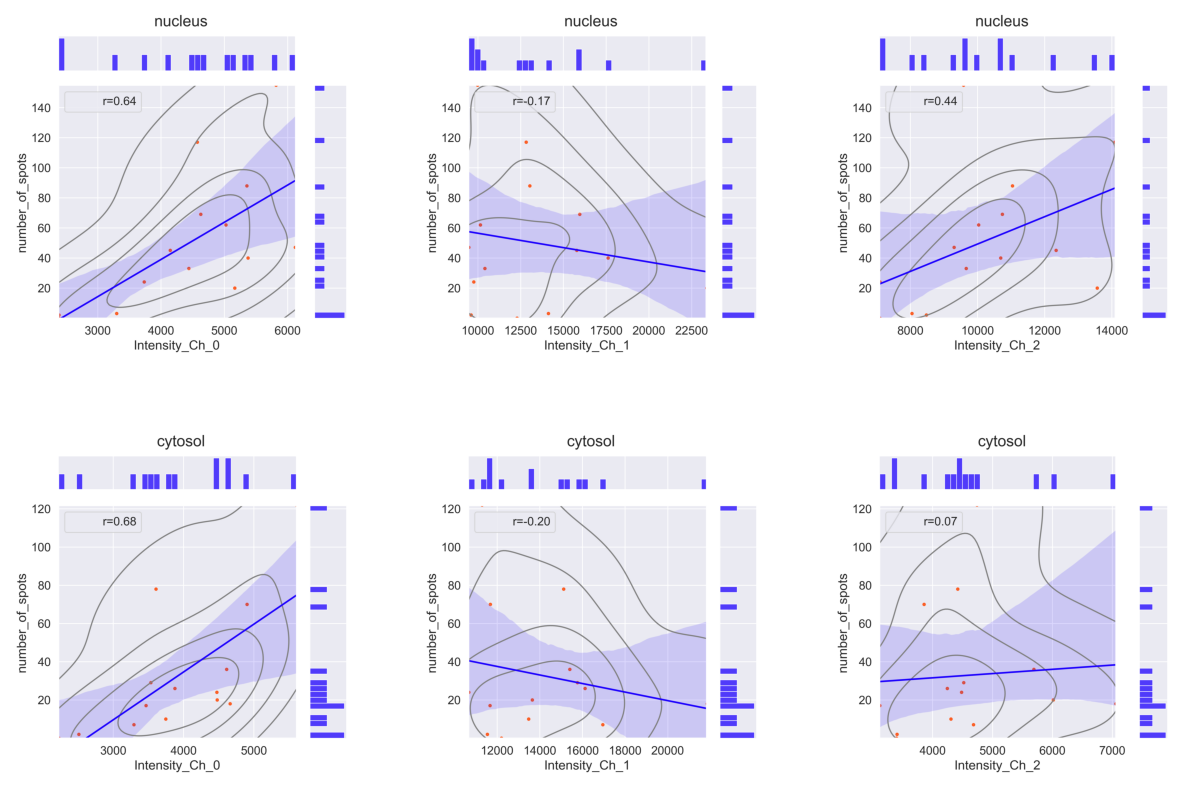

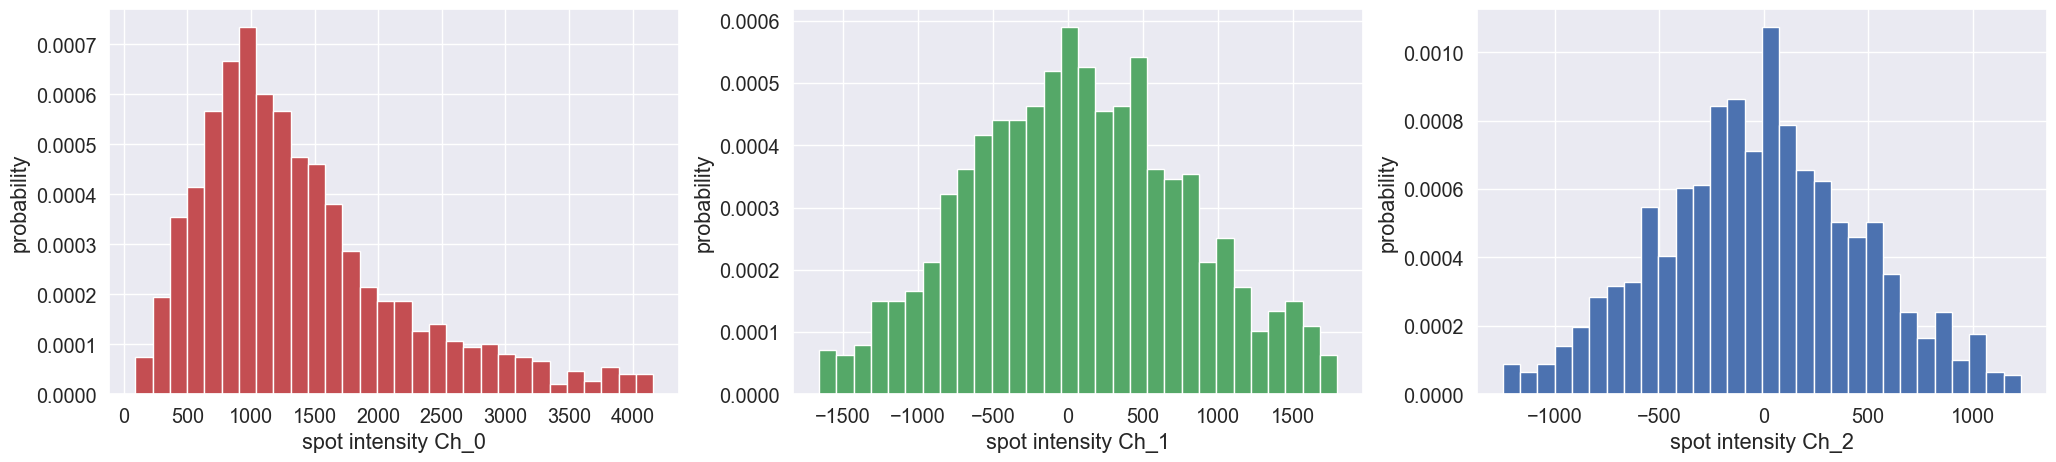

<Figure size 640x480 with 0 Axes>

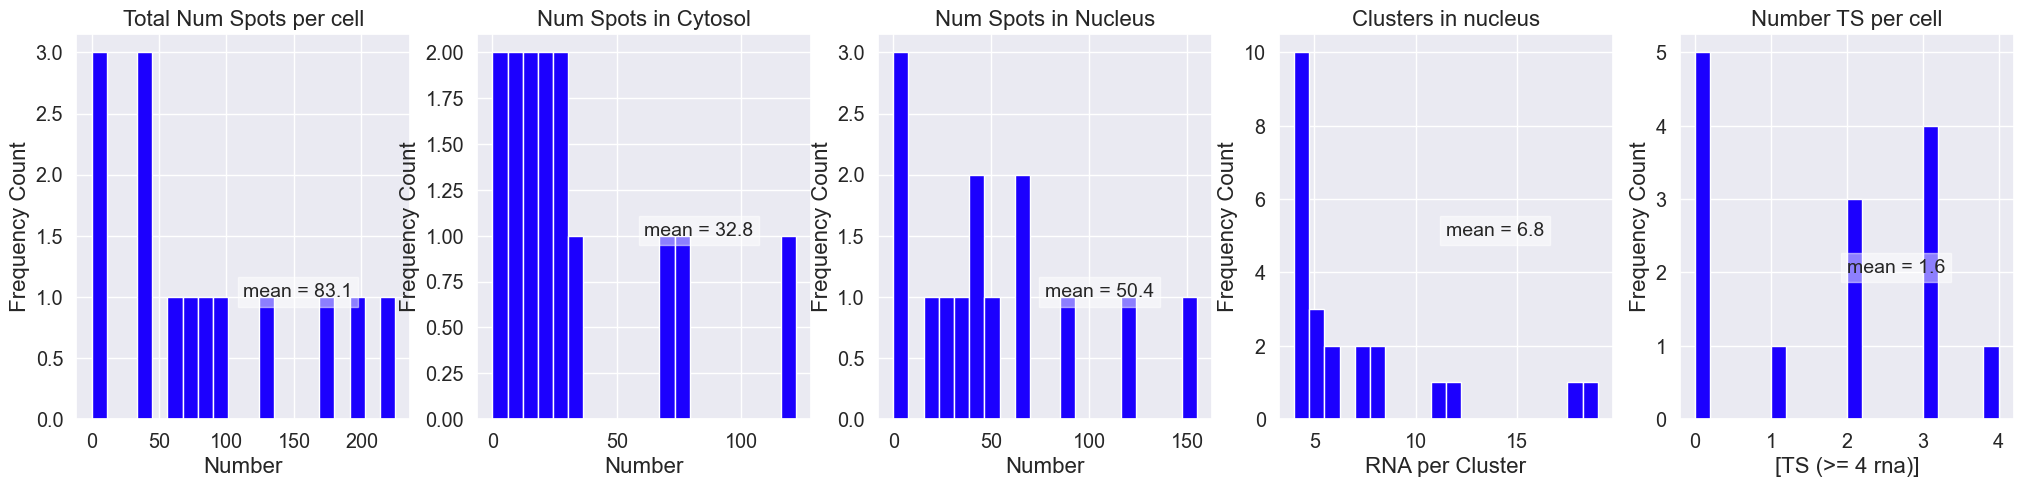

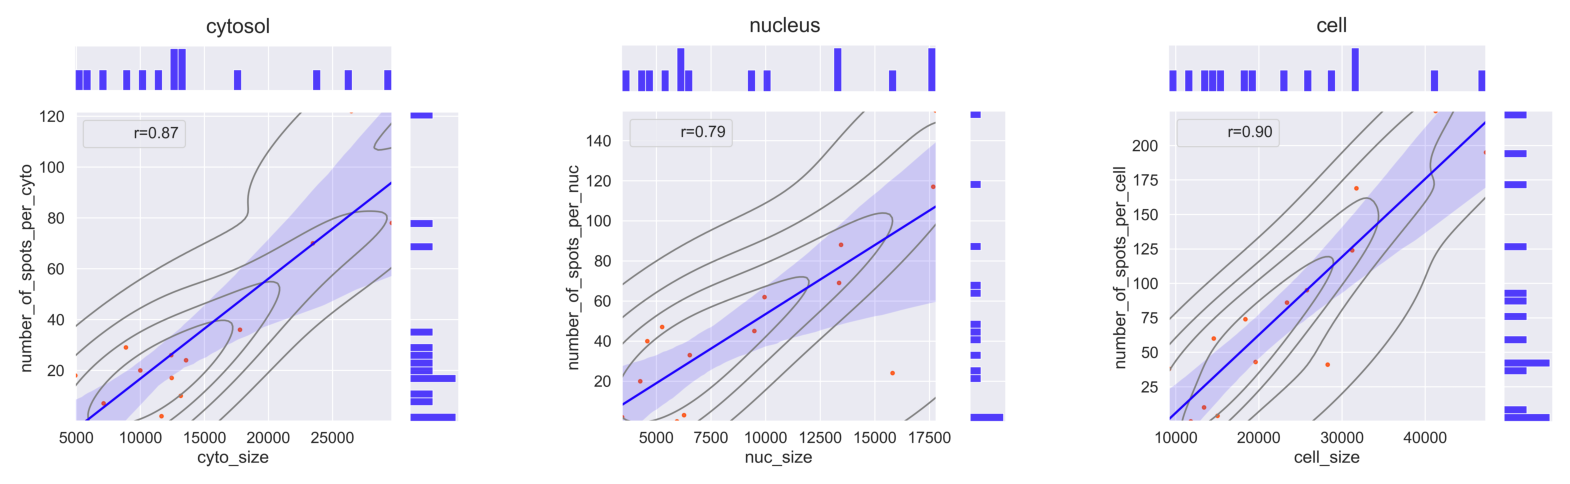

In [13]:
list_files_distributions = fa.Plots().plot_all_distributions(dataframe_FISH,channels_with_cytosol, channels_with_nucleus,channels_with_FISH,minimum_spots_cluster,output_identification_string )

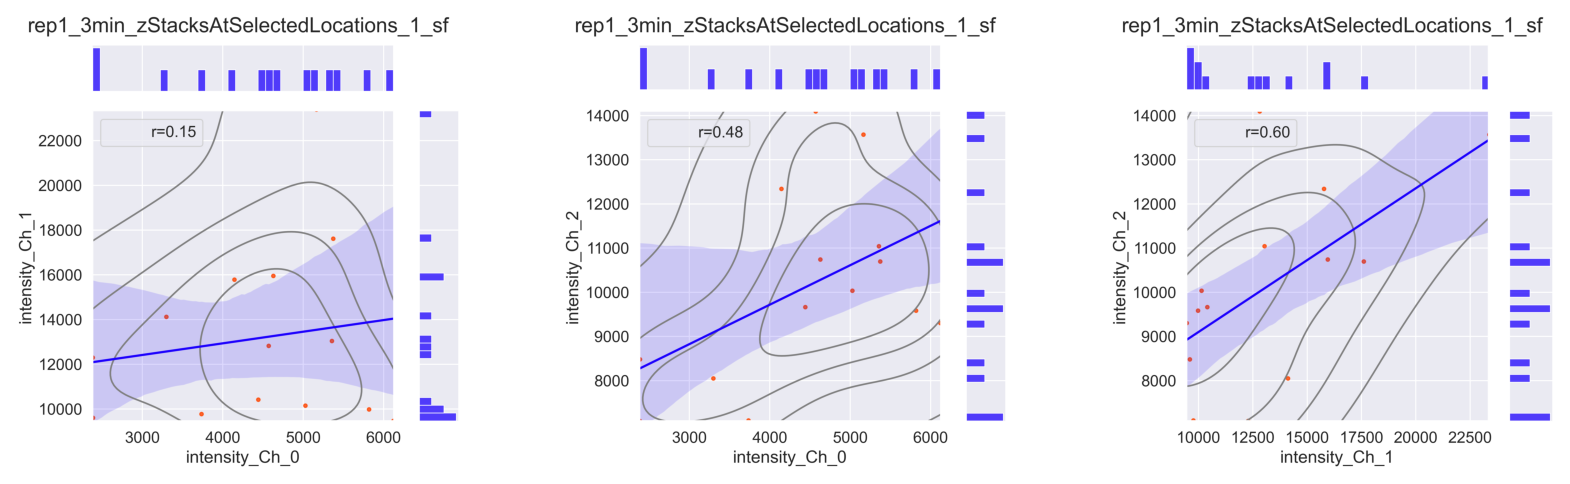

In [14]:
file_plots_bleed_thru = fa.Plots().plot_scatter_bleed_thru(dataframe_FISH, channels_with_cytosol, channels_with_nucleus,output_identification_string)

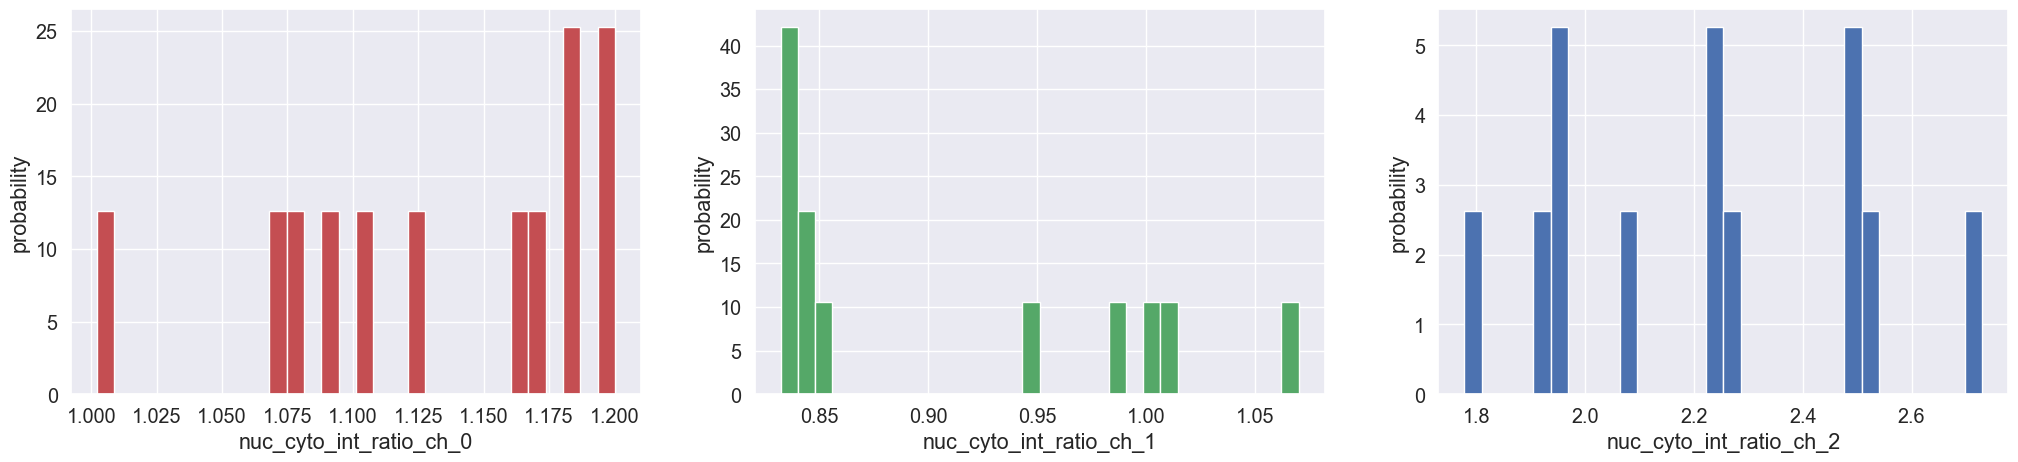

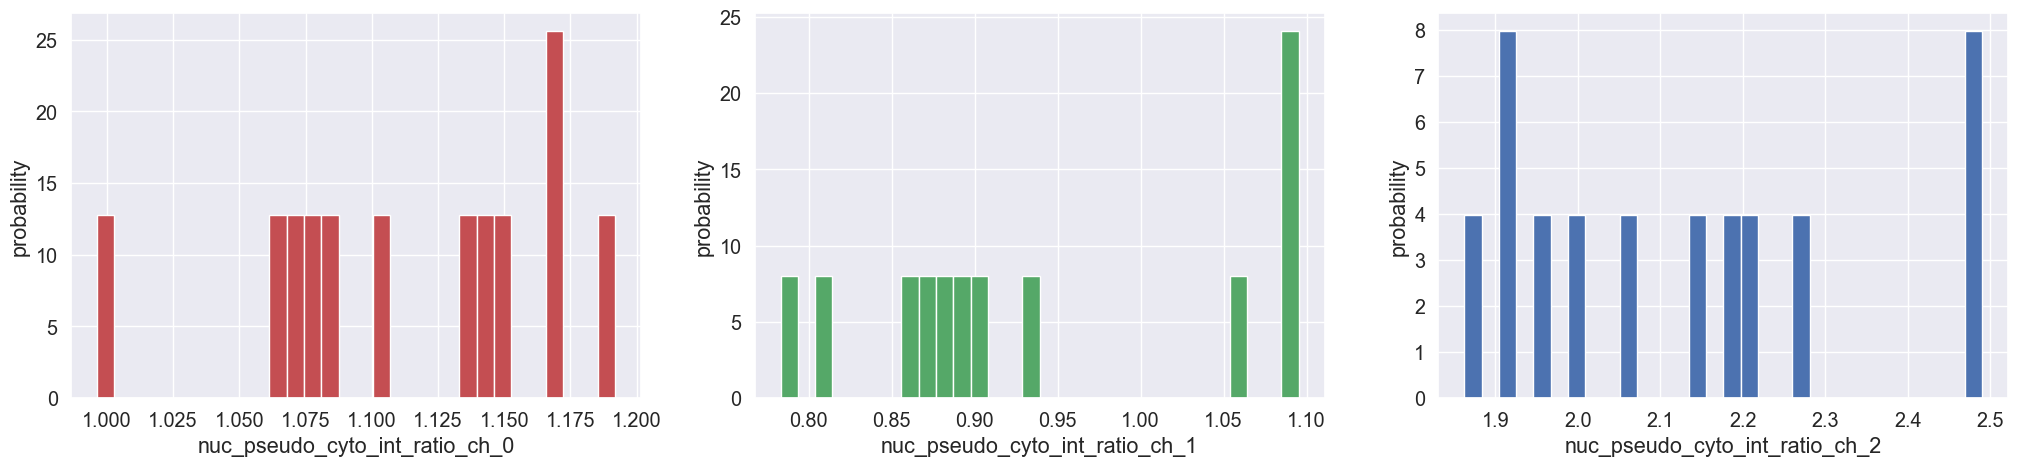

In [15]:
# plots for cytosol nucleus intensity ratios
if not fa.Utilities().is_None(channels_with_cytosol):
    file_plots_int_ratio = fa.Plots().plot_nuc_cyto_int_ratio_distributions(dataframe_FISH,output_identification_string=None,plot_for_pseudo_cytosol=False)
else:
    file_plots_int_ratio = None
file_plots_int_pseudo_ratio = fa.Plots().plot_nuc_cyto_int_ratio_distributions(dataframe_FISH,output_identification_string=None,plot_for_pseudo_cytosol=True)


## Saving data

In [16]:
# Saving data and plots, and sending data to NAS
fa.Utilities().save_output_to_folder(output_identification_string, data_folder_path, 
                                   list_files_distributions=list_files_distributions,
                                   file_plots_bleed_thru=file_plots_bleed_thru,
                                   file_plots_int_ratio=file_plots_int_ratio,
                                   file_plots_int_pseudo_ratio=file_plots_int_pseudo_ratio,
                                   channels_with_FISH=channels_with_FISH,save_pdf_report=save_pdf_report)

# sending data to NAS
analysis_folder_name, mask_dir_complete_name = fa.Utilities().sending_data_to_NAS(output_identification_string, data_folder_path, path_to_config_file, path_to_masks_dir, diameter_nucleus, diameter_cytosol, send_data_to_NAS, masks_dir)

# Moving the complete analysis folder to final analyses folder 
fa.Utilities().move_results_to_analyses_folder( output_identification_string, data_folder_path, mask_dir_complete_name, path_to_masks_dir, save_filtered_images, download_data_from_NAS )